In [9]:
from PIL import Image
from IPython.display import Image as DPImage
import os
import numpy as np
from random import sample
import matplotlib.pyplot as plt
%matplotlib inline
import csv

### Extracting Masks From RLE
Extract and store Masks for validation set from RLE encoding
(This is necessary for the validation set as we only have run length encoded masks for this dataset)

In [199]:
RLE_encodings_file = "./data/stage1_solution.csv"
data_dir = "./data/stage1_test"

with open(RLE_encodings_file, newline='') as csvfile:
    for i, (imgID, RLE, H, W, _) in enumerate(csv.reader(csvfile, delimiter=',')):
        if i == 0: # Skip row with labels
            continue
        H, W = int(H), int(W)
        img = Image.new(mode='1', size=(W, H))
        pixels = img.load()
        RLE_split = list(map(lambda x: int(x), RLE.split()))
        for RLE_i in range(0, len(RLE_split), 2):
            start, length = RLE_split[RLE_i:RLE_i+2]
            for x in range(start, start + length):
                pixels[(x-1)//H, (x-1)%H] = 1

        # Save Mask
        p = f"{data_dir}/{imgID}/masks"
        if not os.path.exists(p):
            os.mkdir(p)
        img.save(f"{p}/mask_{i}.png")


### Create Combined Masks
The model requires the combined masks for each image as label.

In [175]:
# merge a list of masks (arrays) into one mask
def merge_masks(masks):
    # check dimensions
    dim = masks[0].size
    if not all(map(lambda m: m.size == dim, masks)):
        raise AssertionError("All masks must have the same dimensions")

    msum = np.asarray(Image.new(mode='1', size=dim))
    for m in masks:
        msum = np.ma.mask_or(msum, np.asarray(m))
    im = Image.fromarray(msum)
    
    return im

In [201]:
def create_combined_masks(data_directory):
    for img_dir in os.listdir(data_directory):
        p = f"{data_directory}/{img_dir}/combined_masks"
        if not os.path.exists(p):
            os.mkdir(p)
        merge_masks(list(map(
            lambda m: Image.open(f"{data_directory}/{img_dir}/masks/{m}").convert("1"), 
            os.listdir(f"{data_directory}/{img_dir}/masks")
        ))).save(f"{p}/{img_dir}.png")

create_combined_masks("./data/stage1_test")
create_combined_masks("./data/stage1_train")

## Data Exploration
Now we have all the data we can visualize it

670 Training Images

Image:
589f86dee5b480a88dd4f77eeaffe2c4d70aefdf879a4096dde1fa4d41055b8f.png


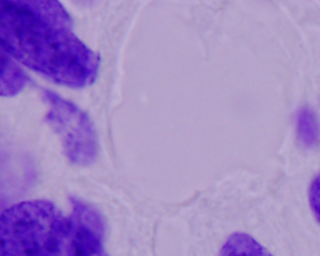

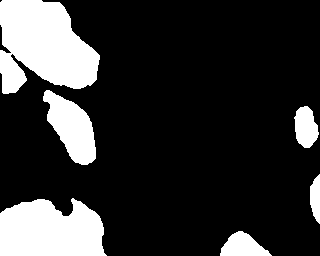

Image:
4327d27591871e9c8d317071a390d1b3dcedad05a9746175b005c41ea0d797b2.png


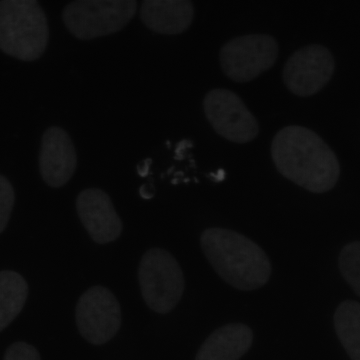

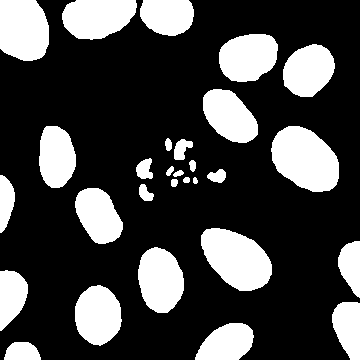

Image:
9a71a416f98971aa14f63ef91242654cc9191a1414ce8bbd38066fe94559aa4f.png


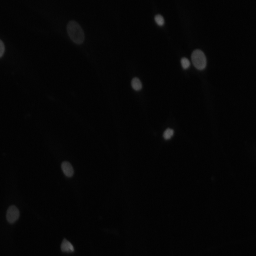

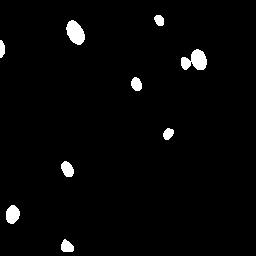

Image:
ac782d2cad7f515ce7276926209820e386248e3d619b2df81e22d5e3c160b7cb.png


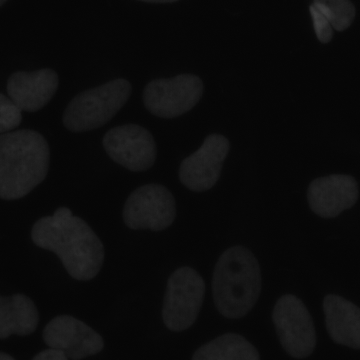

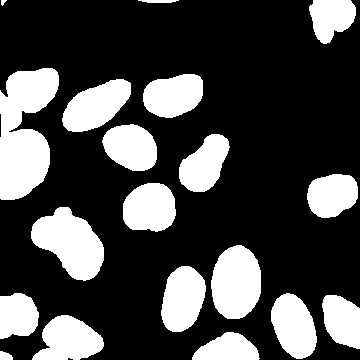

Image:
ec031f176dafe0b36547068ce42eab39428ec7995dac1b3ea52d1db79b61fdeb.png


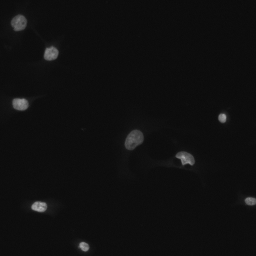

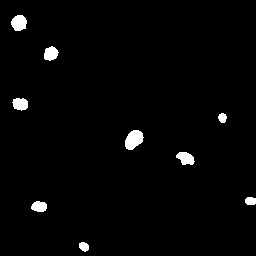

In [24]:
data_dir = "./data/stage1_train"
images_print_amount = 5


tags = os.listdir(data_dir)
print(f"{len(tags)} Training Images")
print()

for i in sample(range(len(tags)), images_print_amount):

    print("Image:")
    path = f"{data_dir}/{tags[i]}/images"
    filename = os.listdir(path)[0]
    print(filename)
    display(DPImage(filename=f"{path}/{filename}"))

    path = f"{data_dir}/{tags[i]}/combined_masks"
    filename = os.listdir(path)[0]
    display(DPImage(filename=f"{path}/{filename}"))

### Data characteristics and distributions

#### 1) Density

Training Data Nucleus Density:


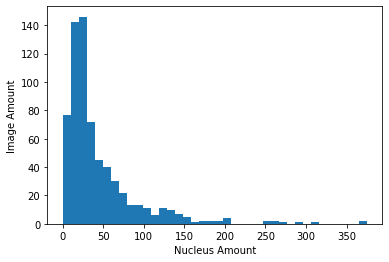

Validation Data Nucleus Density:


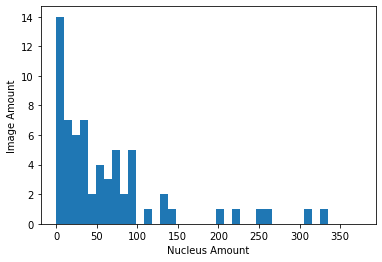

In [23]:
val_data_dir = "./data/stage1_test"
train_data_dir = "./data/stage1_train"

getDensities = lambda data_dir: [len(os.listdir(f"{data_dir}/{imgId}/masks")) for imgId in os.listdir(data_dir)]
val_dens = getDensities(val_data_dir)
train_dens = getDensities(train_data_dir)

highestDensity = max(val_dens + train_dens)

print("Training Data Nucleus Density:")
plt.hist(train_dens, bins=(highestDensity // 10) + 1, range=(0, highestDensity))
plt.xlabel("Nucleus Amount")
plt.ylabel("Image Amount")
plt.show()

print("Validation Data Nucleus Density:")
plt.hist(val_dens, bins=(highestDensity // 10) + 1, range=(0, highestDensity))
plt.xlabel("Nucleus Amount")
plt.ylabel("Image Amount")
plt.show()


#### 2) Color
Grayscale images have only pixels containing the same brightness in each color channel e.g. (RGB) (100, 100, 100)

In [56]:
val_data_dir = "./data/stage1_test"
train_data_dir = "./data/stage1_train"

isGrayscale = lambda pixel: pixel[0] == pixel[1] == pixel[2]

areGrayScale = lambda data_dir: [
    all(map(lambda x: isGrayscale(x), 
            Image.open(f"{data_dir}/{imgId}/images/{os.listdir(f'{data_dir}/{imgId}/images')[0]}").getdata()))
    for imgId in os.listdir(data_dir)]

train_gray = areGrayScale(train_data_dir)
val_gray = areGrayScale(val_data_dir)

Training Data grayscale/color distribution:


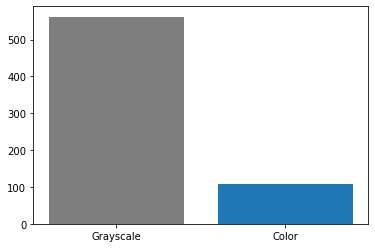

Validation Data grayscale/color distribution:


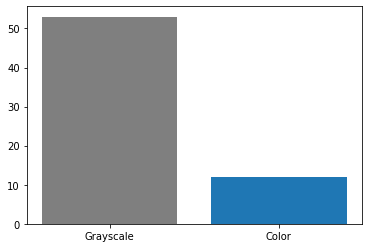

In [70]:
labels = ["Grayscale", "Color"]
colors = ["tab:gray", "tab:blue"]

val_counts = [sum(val_gray), len(val_gray) - sum(val_gray)]
train_counts = [sum(train_gray), len(train_gray) - sum(train_gray)]

print("Training Data grayscale/color distribution:")
plt.bar(labels, train_counts, color=colors)
plt.show()

print("Validation Data grayscale/color distribution:")
plt.bar(labels, val_counts, color=colors)
plt.show()

#### 3) Brightness
Some Images have a higher brightness than others (can be fixed with pre-processing).
(Brightness is calculated by taking the highest value in any color channel)

Training Data Brightness:


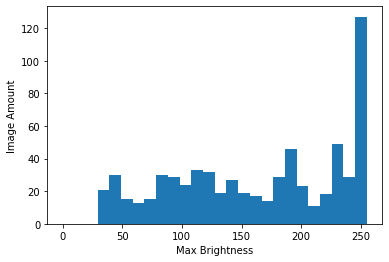

Validation Data Brightness:


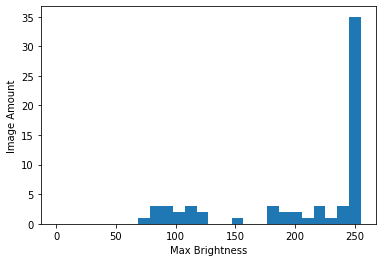

In [71]:
val_data_dir = "./data/stage1_test"
train_data_dir = "./data/stage1_train"

maxPixelValue = lambda pixels: max(map(lambda x: max(x[:2]), pixels))

maxPixelValues = lambda data_dir: [maxPixelValue(Image.open(f"{data_dir}/{imgId}/images/{os.listdir(f'{data_dir}/{imgId}/images')[0]}").getdata()) for imgId in os.listdir(data_dir)]

train_brightness = maxPixelValues(train_data_dir)
val_brightness = maxPixelValues(val_data_dir)

print("Training Data Brightness:")
plt.hist(train_brightness, bins=(255 // 10) + 1, range=(0, 255))
plt.xlabel("Max Brightness")
plt.ylabel("Image Amount")
plt.show()

print("Validation Data Brightness:")
plt.hist(val_brightness, bins=(255 // 10) + 1, range=(0, 255))
plt.xlabel("Max Brightness")
plt.ylabel("Image Amount")
plt.show()